In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

2024-01-19 16:16:36.165212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 16:16:36.199278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 16:16:36.728707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow recognized 0 GPUs


2024-01-19 16:16:42.732912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Load DNN Model

View the model layers

In [2]:
model_mnist = keras.models.load_model('models/cnnClassifier.h5')
model_mnist.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

### Load Data

Load Data and test model

In [3]:
import random
import numpy as np
import gzip

popsize = 10

def load_mnist_test(popsize, number):
    file_test_x = './original_dataset/t10k-images-idx3-ubyte.gz'
    file_test_y = './original_dataset/t10k-labels-idx1-ubyte.gz'

    with gzip.open(file_test_x, 'rb') as f:
        _ = np.frombuffer(f.read(16), dtype=np.uint8, count=4)
        images = np.frombuffer(f.read(), dtype=np.uint8)
        test_x = images.reshape(-1, 28, 28)

    with gzip.open(file_test_y, 'rb') as f:
        _ = np.frombuffer(f.read(8), dtype=np.uint8, count=2)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        test_y = labels

    idx = [i for i, label in enumerate(test_y) if label == number]
    #print(f"number of {number} is {len(idx)}")
    filtered_test_y = test_y[idx]
    filtered_test_x = test_x[idx]

    if popsize<filtered_test_y.shape[0]:
        return filtered_test_x[:popsize], filtered_test_y[:popsize]
    else:
        return filtered_test_x, filtered_test_y
    
for number in range(10):
    x_test, y_test = load_mnist_test(popsize, number)
    print(f"Label: {number}")
    image = x_test[random.randint(0, popsize-1)]
    input = np.reshape(image, (1, 28, 28))
    print(f"Prediction: {model_mnist.predict(input)}")
    

Label: 0
1/1 [==============================] - 0s 64ms/step
Prediction: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Label: 1
1/1 [==============================] - 0s 14ms/step
Prediction: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Label: 2
1/1 [==============================] - 0s 15ms/step
Prediction: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Label: 3
1/1 [==============================] - 0s 15ms/step
Prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Label: 4
1/1 [==============================] - 0s 16ms/step
Prediction: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Label: 5
1/1 [==============================] - 0s 16ms/step
Prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Label: 6
1/1 [==============================] - 0s 16ms/step
Prediction: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Label: 7
1/1 [==============================] - 0s 16ms/step
Prediction: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Label: 8
1/1 [==============================] - 0s 18ms/step
Prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Label: 9
1/1 [=======================

## model_modifiers and CategoricalScore

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use ReplaceToLinear instance here, we can also use the model modifier function defined by ourselves.

And then, you MUST create Score instance or define score function that returns target scores.

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

from tf_keras_vis.utils.scores import CategoricalScore



## Vanilla Saliency

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

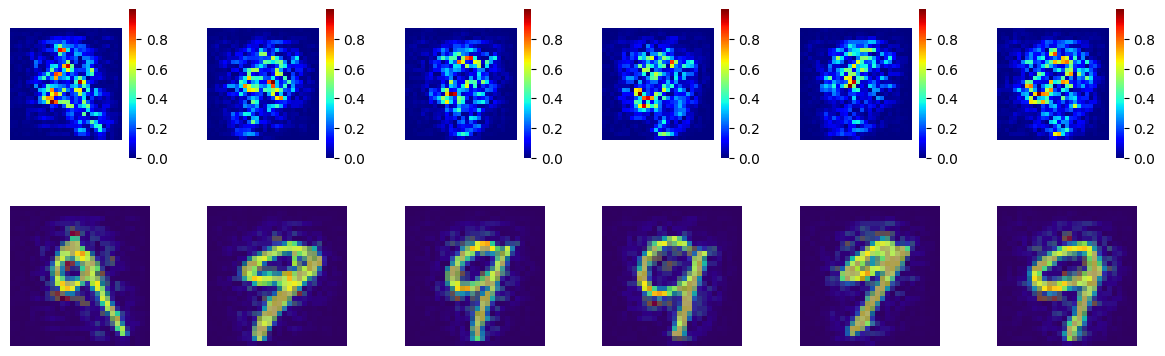

<Figure size 900x1000 with 0 Axes>

In [5]:
import seaborn as sns
from tf_keras_vis.saliency import Saliency

# generate input 
%matplotlib inline

popsize = 6
number = 9
score = CategoricalScore(number)

def get_input(num, popsize):
    x_test, y_test = load_mnist_test(popsize, num)

    X = np.reshape(x_test, (popsize, 28, 28, 1))
    X = X.astype('float32')
    # X /= 255.0
    return X

X = get_input(number, popsize)

# Create Saliency object.
saliency = Saliency(model_mnist,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)


def plot_all(saliency_map, X, popsize = popsize):
    # Render
    rows = 2
    f, ax = plt.subplots(nrows=rows, ncols=popsize, figsize=(12, 4))
    plt.tight_layout()
    
    fig = plt.figure(figsize=(9, 10))
    row = 0
    for i in range(popsize):
        sns.heatmap(saliency_map[i], ax=ax[row, i], square=True, cmap="jet")
        #ax[row, i].imshow(saliency_map[i], cmap="jet")
        ax[row, i].axis('off')
    
    row += 1
    for i in range(popsize):
        ax[row, i].imshow(X[i])
        ax[row, i].imshow(saliency_map[i], cmap='jet', alpha = 0.3)
        ax[row, i].axis('off')

    
plot_all(saliency_map, X)

## SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce the noise in saliency map by adding noise to input image.

**Note:** Because SmoothGrad calculates the gradient repeatedly, it might take much time around 2-3 minutes when using CPU.

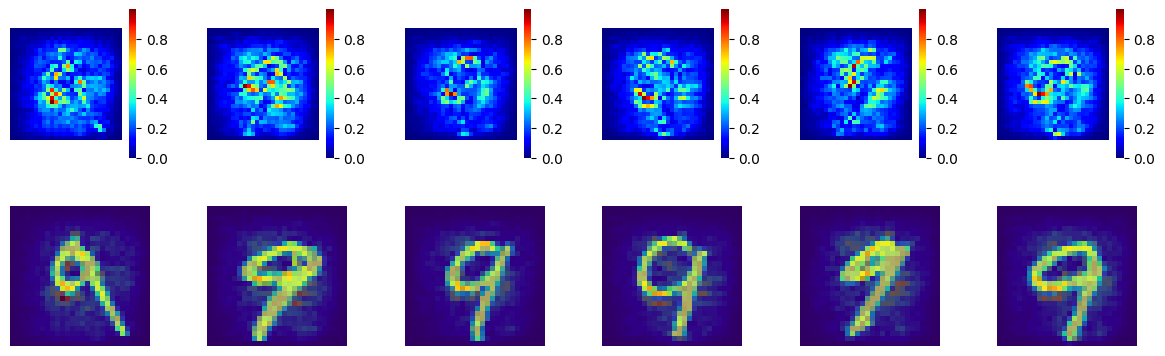

<Figure size 900x1000 with 0 Axes>

In [6]:
number = 9

score = CategoricalScore([number])

X = get_input(number, popsize)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
plot_all(saliency_map, X)

## GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

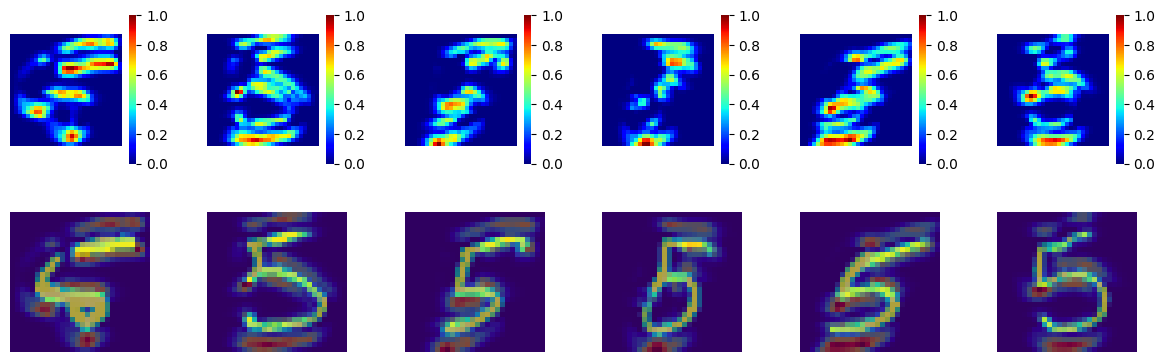

<Figure size 900x1000 with 0 Axes>

In [7]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

number = 5

score = CategoricalScore(number)
X = get_input(number, popsize)
X *= 2.0

# Create Gradcam object
gradcam = Gradcam(model_mnist,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)


## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
plot_all(cam, X)

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

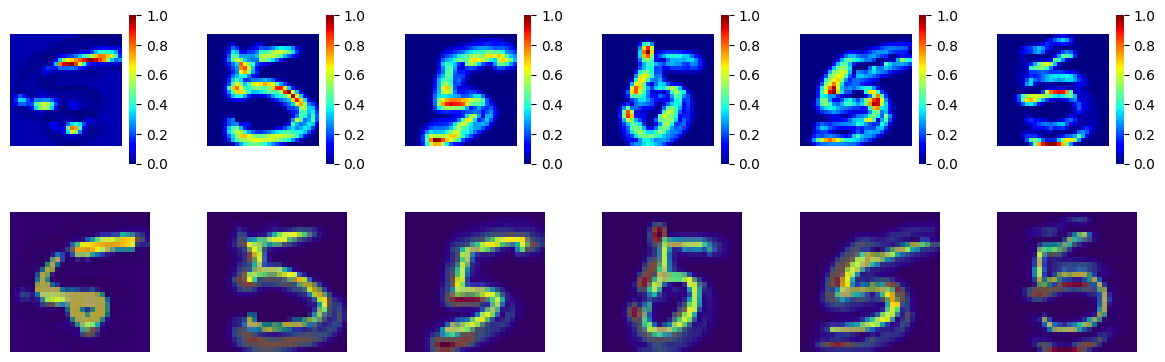

<Figure size 900x1000 with 0 Axes>

In [8]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


number = 5

score = CategoricalScore([number])

X = get_input(number, popsize)
# NOTE for GradCAM++ input must be normalized !!!
X /= 255.0

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model_mnist,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
plot_all(cam, X)

# ScoreCAM

In the end, Here, we show you ScoreCAM. It is an another method that generates Class Activation Map. The characteristic of this method is that it's the `gradient-free` method unlike GradCAM, GradCAM++ or Saliency.

12/12 [==============================] - 0s 7ms/step


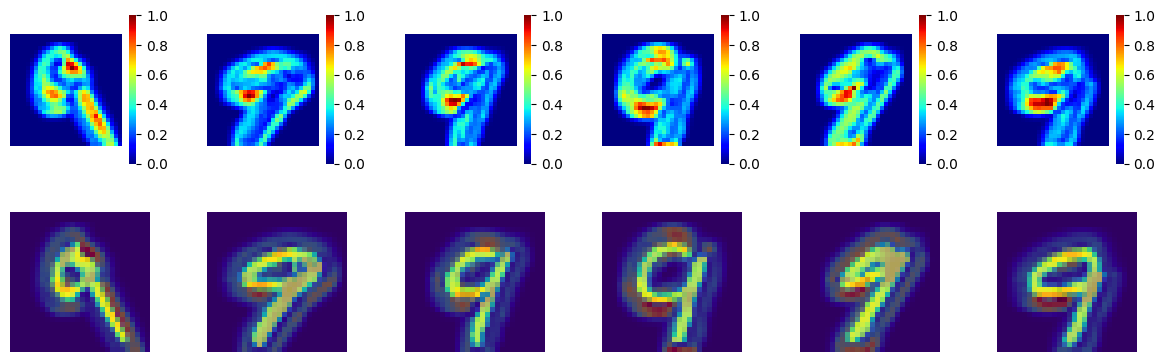

<Figure size 900x1000 with 0 Axes>

In [9]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

number = 9
score = CategoricalScore([number])
X = get_input(number, popsize)
# NOTE for GradCAM++ input must be normalized !!!
#X /= 55.0

# Create ScoreCAM object
scorecam = Scorecam(model_mnist)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
plot_all(cam, X)

## Faster-ScoreCAM

ScoreCAM is a great method, however, it takes a bit more time to process it than other cam methods.
There is a good news for us. Faster-ScorecAM that makes ScoreCAM to be more efficient was devised by @tabayashi0117.

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam

> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).


6/6 [==============================] - 0s 6ms/step


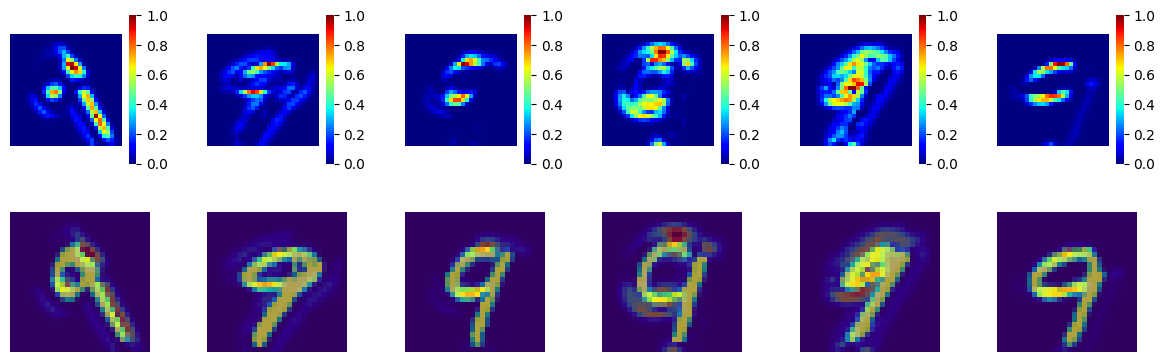

<Figure size 900x1000 with 0 Axes>

In [10]:
from tf_keras_vis.scorecam import Scorecam

number = 9
score = CategoricalScore([number])
X = get_input(number, popsize)
# NOTE for GradCAM++ input must be normalized !!!


# Create ScoreCAM object
scorecam = Scorecam(model_mnist, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
plot_all(cam, X)

## Integrated gradients

The IntegratedGradients class implements the integrated gradients attribution method. 

In the following example, the baselines (i.e. the starting points of the path integral) are black images (all pixel values are set to zero). This means that black areas of the image will always have zero attribution. The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.


In [17]:
from alibi.explainers import IntegratedGradients

n_steps = 20
method = "gausslegendre"
ig  = IntegratedGradients(model_mnist,
                          n_steps=n_steps, 
                          method="gausslegendre")

2024-01-19 16:25:21.580759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [120]
	 [[{{node Placeholder/_1}}]]


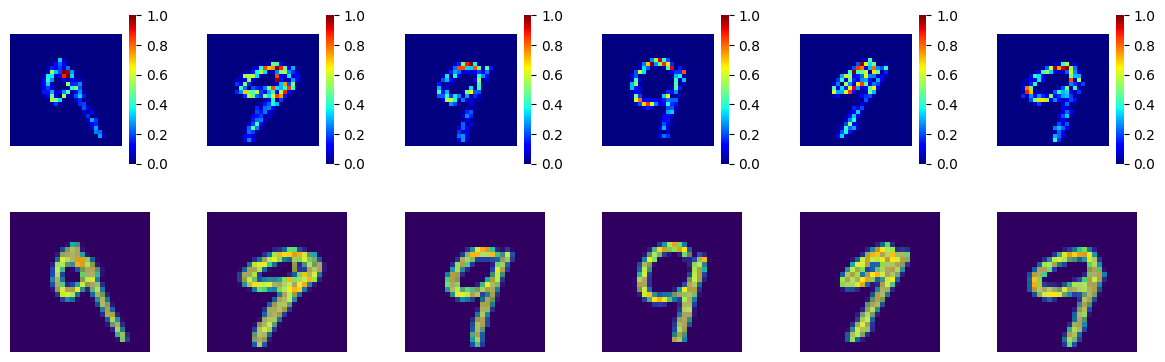

<Figure size 900x1000 with 0 Axes>

In [21]:
X = get_input(number, popsize)

predictions = model_mnist(X).numpy().argmax(axis=1)

explanation = ig.explain(X, 
                         baselines=None, 
                         target=predictions)

attributions = explanation.attributions[0]
# remove single-dimensional shape of the array.
# attributions = attributions.squeeze()
attributions = np.reshape(attributions, (-1, 28, 28))
# only focus on positive part
# attributions = attributions.clip(0, 1)
attributions = np.abs(attributions)
normalized_attributions = np.zeros(shape=attributions.shape)

# Normalization
for i in range(attributions.shape[0]):
    try:
        # print(f"attention map difference {np.max(attributions[i]) - np.min(attributions[i])}")
        normalized_attributions[i] = (attributions[i] - np.min(attributions[i])) / (np.max(attributions[i]) - np.min(attributions[i]))
    except ZeroDivisionError:
        print("Error: Cannot divide by zero")
        
# print(normalized_attributions.shape)

plot_all(normalized_attributions, X)